### Interpretability of Acustic Emission Sound Data classification using a CNN model and Grad-CAM

In [1]:
# Imports
import numpy as np
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, BatchNormalization, Activation, Conv2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import activations
from itertools import islice
from sklearn.preprocessing import normalize
sns.set()

length = 277

2022-10-13 11:10:32.443253: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-13 11:10:32.516371: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-13 11:10:32.532809: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-13 11:10:32.822113: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [2]:
from pandas import read_csv
from numpy import set_printoptions
from sklearn import datasets, linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
import numpy as np
import pathlib

# Using GPU
import os
import scipy.io as scpy
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'  # Set to -1 if CPU should be used CPU = -1 , GPU = 0

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
elif cpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_cpus= tf.config.experimental.list_logical_devices('CPU')
        print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


2022-10-13 11:10:33.536539: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 11:10:33.557004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 11:10:33.557150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 11:10:33.557789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

### Extract task-specific data and labels

In [4]:
from pandas import read_csv
from numpy import set_printoptions
from sklearn import datasets, linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import random
# Using GPU
import os
import scipy.io as scpy

data = scpy.loadmat("all-data.mat")
# Extracting x_train from the mat file dictionary.
x_data = data["XTrain"]
# Extracting y_train from the mat file dictionary.
y_data = data["y_train"]
# Converting x_train and y_train to a numpy array.
x_data = np.array(x_data,dtype='float32')
y_data = np.array(y_data,dtype='float32')-1
x_temp_data=data['XTest']
y_temp_data=data['y_test']
x_temp_data=np.array(x_temp_data,dtype='float32')
y_temp_data=np.array(y_temp_data,dtype='float32')-1
# x_data=np.concatenate((x_data,x_temp_data),axis=0)
# y_data=np.concatenate((y_data,y_temp_data),axis=0)

# Verifying the shapes.
print(x_data.shape)
print(y_data.shape)

SEED = 99
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
# split into train test sets
x_train, x_val_to_use, y_train, y_val_to_use = train_test_split(x_data, y_data, test_size=0.3, random_state=SEED)
x_val, x_test, y_val, y_test = train_test_split(x_val_to_use, y_val_to_use, test_size=0.5, random_state=SEED)

print(f" {len(x_train), len(x_val), len(x_test)}")
print(f" {len(y_train), len(y_val), len(y_test)}")
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
BATCH_SIZE = 64
# SHUFFLE_BUFFER_SIZE = 100
train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


(15000, 1000)
(15000, 1)
 (10500, 2250, 2250)
 (10500, 2250, 2250)


In [5]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)


(10500, 1000)
(10500, 1)
(2250, 1000)
(2250, 1)
(2250, 1000)
(2250, 1)


In [25]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, AddGaussianSNR
from audiomentations import ClippingDistortion, PolarityInversion, Gain
import numpy as np

augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.7),
    AddGaussianSNR(min_snr_in_db=4.0, max_snr_in_db=30.0, p=0.7),
    ClippingDistortion(min_percentile_threshold=0, max_percentile_threshold=1, p=0.5),
    PolarityInversion(p=0.5),
    Gain(min_gain_in_db=-6, max_gain_in_db=6, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.5, p=0.6),
    PitchShift(min_semitones=-5, max_semitones=7, p=0.3),
    Shift(min_fraction=-0.75, max_fraction=0.75, p=0.4),
])

# plt.plot(x_train[120])
# Augment/transform/perturb the audio data
augemnted_data = augment(samples=x_train, sample_rate=16000)
x_train = np.concatenate((x_train, augemnted_data), axis=0)
y_train = np.concatenate((y_train, y_train), axis=0)

/home/veysiadn/anaconda3/lib/python3.9/site-packages/audiomentations/core/transforms_interface.py:66: UserWarning: Multichannel audio must have channels first, not channels last. In other words, the shape must be (channels, samples), not (samples, channels)
  warnings.warn(
/home/veysiadn/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1000
  return f(*args, **kwargs)


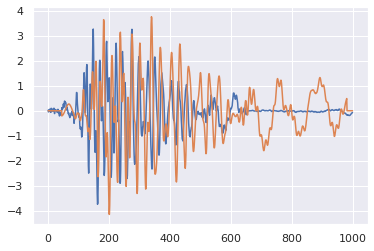

In [27]:
plt.plot(augemnted_data[50])
plt.plot(x_train[50])

In [28]:
print(x_train.shape)
print(y_train.shape)

(23310, 1000)
(23310, 1)


### Build the CNN architecture, train, and predict on the test set

In [24]:
# import tensorflow as tf
# tf.compat.v1.disable_eager_execution()

verbose, epoch, batch_size = 1, 100, 128
activationFunction='relu'

def getModel(): 
    cnnmodel = Sequential()
    cnnmodel.add(tf.keras.layers.Reshape((x_train.shape[1],1,1), input_shape=(1000,)))
    cnnmodel.add(tf.keras.layers.Conv2D(filters=2, kernel_size=4,padding='same', activation=activationFunction,name='last_conv_layer'))
    cnnmodel.add(tf.keras.layers.MaxPooling2D(pool_size=4,padding='same'))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(4, activation=activationFunction))
    cnnmodel.add(Dense(3, activation='softmax'))
    cnnmodel.summary()
    cnnmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
    return cnnmodel

cnnmodel = getModel()
cnnhistory= cnnmodel.fit(x_train, y_train, epochs=epoch, verbose=verbose, validation_data=(x_val, y_val), batch_size = batch_size)

# Plotting accuracy and loss
import matplotlib.pyplot as plt
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.plot(cnnhistory.history['val_loss'])


plt.title('Model loss & accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['tr_loss', 'tr_accuracy', 'val_acc', 'val_loss'], loc='lower right')
# accuracy!
print("Training results")
print(f"Training Accuracy: {cnnhistory.history['accuracy'][-1]}")
print(f"Training Loss: {cnnhistory.history['loss'][-1]}")

# evaluating model
print("Evaluation results")
print(f"Validation Accuracy: {cnnhistory.history['val_accuracy'][-1]}")
print(f"Validation Loss: {cnnhistory.history['val_loss'][-1]}")


plt.show()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_17 (Reshape)        (None, 1000, 1, 1)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 1000, 1, 64)       2624      
                                                                 
 depthwise_conv2d_12 (Depthw  (None, 334, 1, 64)       262208    
 iseConv2D)                                                      
                                                                 
 depthwise_conv2d_13 (Depthw  (None, 112, 1, 64)       262208    
 iseConv2D)                                                      
                                                                 
 depthwise_conv2d_14 (Depthw  (None, 38, 1, 64)        262208    
 iseConv2D)                                                      
                                                     

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_17/depthwise_conv2d_12/depthwise' defined at (most recent call last):
    File "/home/veysiadn/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/veysiadn/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/veysiadn/anaconda3/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/veysiadn/anaconda3/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/veysiadn/anaconda3/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_239977/670307657.py", line 25, in <cell line: 25>
      cnnhistory= cnnmodel.fit(x_train, y_train, epochs=epoch, verbose=verbose, validation_data=(x_val, y_val), batch_size = batch_size)
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/engine/sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/layers/convolutional/depthwise_conv2d.py", line 161, in call
      outputs = backend.depthwise_conv2d(
    File "/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/backend.py", line 6315, in depthwise_conv2d
      x = tf.compat.v1.nn.depthwise_conv2d(
Node: 'sequential_17/depthwise_conv2d_12/depthwise'
Current implementation only supports equal length strides in the row and column dimensions.
	 [[{{node sequential_17/depthwise_conv2d_12/depthwise}}]] [Op:__inference_train_function_3994]

In [18]:
# # Save the model so we can visualize it with Netron (https://github.com/lutzroeder/netron):
tf.keras.models.save_model(cnnmodel, 'cnnmodel_gradcamcam_ecg_paper.h5')

### Choose a class to get the Grad-CAM values for

27/27 [==============================] - 0s 691us/step
Tensile Class(0) Validation data mean : 0.0007343743927776814
Tensile Class(0) Validation data std : 0.8072059154510498
27/27 [==============================] - 0s 656us/step
Tensile Class(0) Test data mean : -0.01588386483490467
Tensile Class(0) Test data std : 0.763221263885498


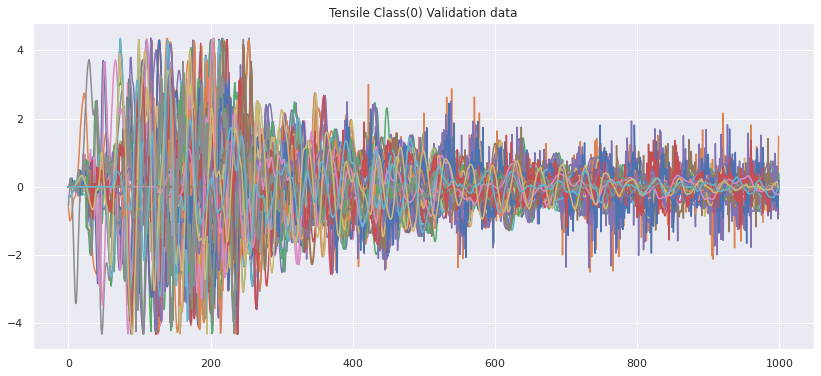

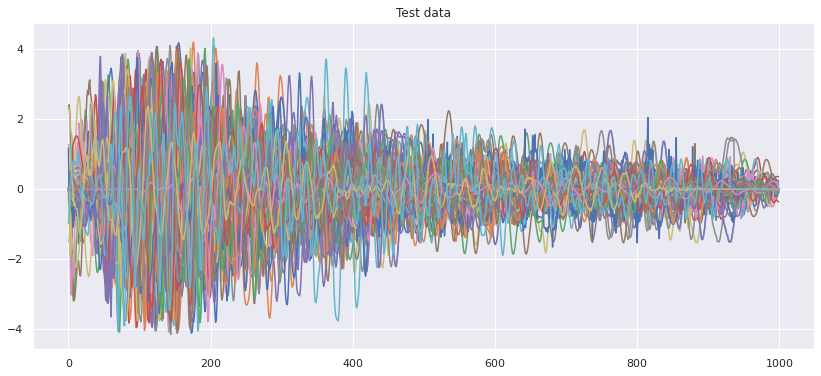

In [34]:
# Get all the data that corresponds to one single class (class 8 / 'I'):
samples=100
class_num = 0
class_indices = np.where(y_test == class_num)[0]
class_data = x_test[class_indices]
class_output = y_test[class_indices]
class_ann = 'T'   # 'S'for one and 'M' for 2
cnnpredictions = cnnmodel.predict(class_data, verbose=1)
print(f"Tensile Class(0) Validation data mean : {class_data.mean()}")
print(f"Tensile Class(0) Validation data std : {class_data.std()}")
# Get all the data that corresponds to one single class (class 8 / 'I'):
test_class_indices = np.where(y_temp_data == class_num)[0]
test_class_data = x_temp_data[test_class_indices]
test_class_output = y_temp_data[test_class_indices]
test_class_ann = 'T'   # 'S'for one and 'M' for 2
test_cnnpredictions = cnnmodel.predict(class_data, verbose=1)
plt.figure(figsize=(14, 6))
plt.title('Tensile Class(0) Validation data')
for i in range(samples):
    plt.plot(test_class_data[i])
print(f"Tensile Class(0) Test data mean : {test_class_data.mean()}")
print(f"Tensile Class(0) Test data std : {test_class_data.std()}")
# print(test_class_output.shap)
plt.figure(figsize=(14, 6))
plt.title('Test data')
for i in range(samples):
    plt.plot(class_data[i])

24/24 [==============================] - 0s 987us/step
Shear Class(1) Validation data mean : -0.001129838521592319
Shear Class(1) Validation data std : 1.0747125148773193
24/24 [==============================] - 0s 569us/step
Shear Class(1) Test data mean : -0.006945035886019468
Shear Class(1) Test data std : 0.9224506616592407


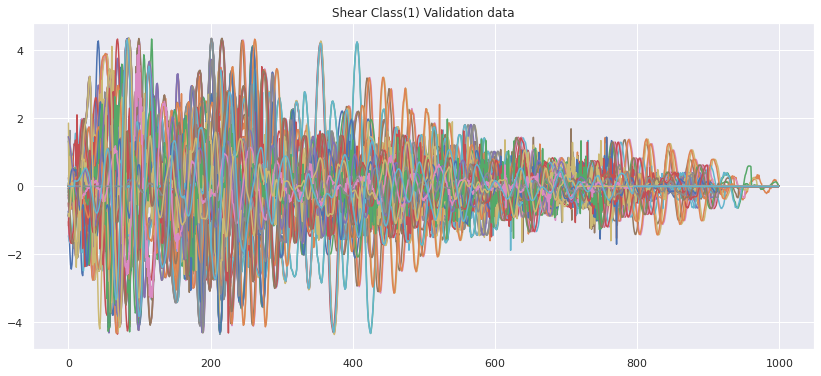

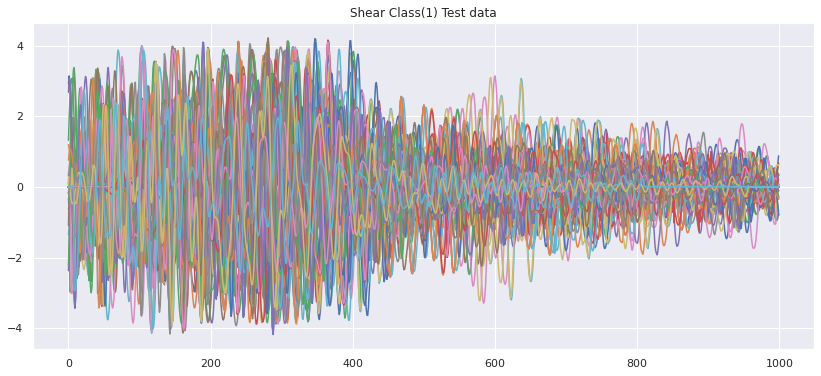

In [128]:
# Get all the data that corresponds to one single class (class 8 / 'I'):
class_num = 1
class_indices = np.where(y_test == class_num)[0]
class_data = x_test[class_indices]
class_output = y_test[class_indices]
class_ann = 'T'   # 'S'for one and 'M' for 2
cnnpredictions = cnnmodel.predict(class_data, verbose=1)
print(f"Shear Class(1) Validation data mean : {class_data.mean()}")
print(f"Shear Class(1) Validation data std : {class_data.std()}")
# Get all the data that corresponds to one single class (class 8 / 'I'):
test_class_indices = np.where(y_temp_data == class_num)[0]
test_class_data = x_temp_data[test_class_indices]
test_class_output = y_temp_data[test_class_indices]
test_class_ann = 'T'   # 'S'for one and 'M' for 2
test_cnnpredictions = cnnmodel.predict(class_data, verbose=1)
plt.figure(figsize=(14, 6))
plt.title('Shear Class(1) Validation data')
for i in range(samples):
    plt.plot(test_class_data[i])
print(f"Shear Class(1) Test data mean : {test_class_data.mean()}")
print(f"Shear Class(1) Test data std : {test_class_data.std()}")
# print(test_class_output.shap)
plt.figure(figsize=(14, 6))
plt.title('Shear Class(1) Test data')
for i in range(samples):
    plt.plot(class_data[i])

24/24 [==============================] - 0s 725us/step
Mix Class(2) Validation data mean : -0.0006461656303144991
Mix Class(2) Validation data std : 1.0819026231765747
24/24 [==============================] - 0s 549us/step
Mix Class(2) Test data mean : -0.005947176832705736
Mix Class(2) Test data std : 0.9606236219406128


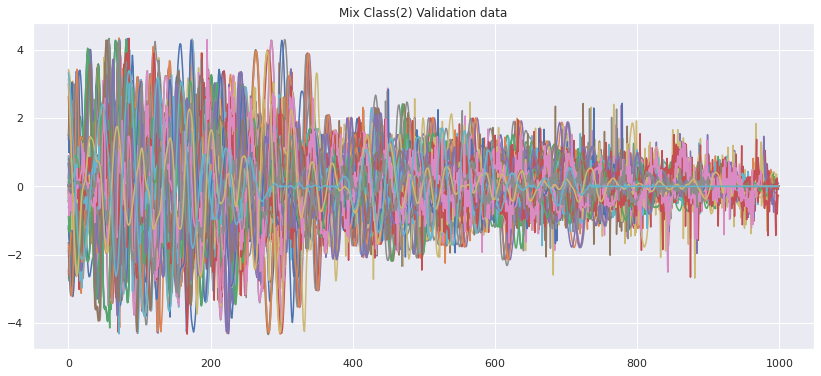

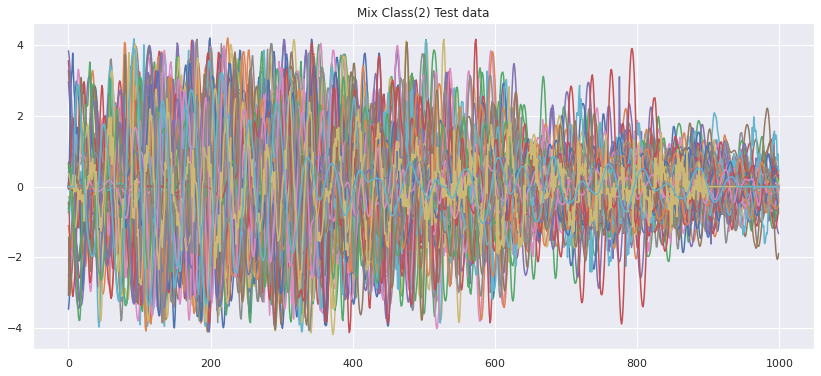

In [129]:
# Get all the data that corresponds to one single class (class 8 / 'I'):
class_num = 2
class_indices = np.where(y_test == class_num)[0]
class_data = x_test[class_indices]
class_output = y_test[class_indices]
class_ann = 'T'   # 'S'for one and 'M' for 2
cnnpredictions = cnnmodel.predict(class_data, verbose=1)
print(f"Mix Class(2) Validation data mean : {class_data.mean()}")
print(f"Mix Class(2) Validation data std : {class_data.std()}")
# Get all the data that corresponds to one single class (class 8 / 'I'):
test_class_indices = np.where(y_temp_data == class_num)[0]
test_class_data = x_temp_data[test_class_indices]
test_class_output = y_temp_data[test_class_indices]
test_class_ann = 'T'   # 'S'for one and 'M' for 2
test_cnnpredictions = cnnmodel.predict(class_data, verbose=1)
plt.figure(figsize=(14, 6))
plt.title('Mix Class(2) Validation data')
for i in range(samples):
    plt.plot(test_class_data[i])
print(f"Mix Class(2) Test data mean : {test_class_data.mean()}")
print(f"Mix Class(2) Test data std : {test_class_data.std()}")
# print(test_class_output.shap)
plt.figure(figsize=(14, 6))
plt.title('Mix Class(2) Test data')
for i in range(samples):
    plt.plot(class_data[i])

24/24 [==============================] - 0s 609us/step
Validation data mean : -0.001129838521592319
Validation data std : 1.0747125148773193
24/24 [==============================] - 0s 594us/step
Test data mean : -0.0009916312992572784
Test data std : 1.0753182172775269


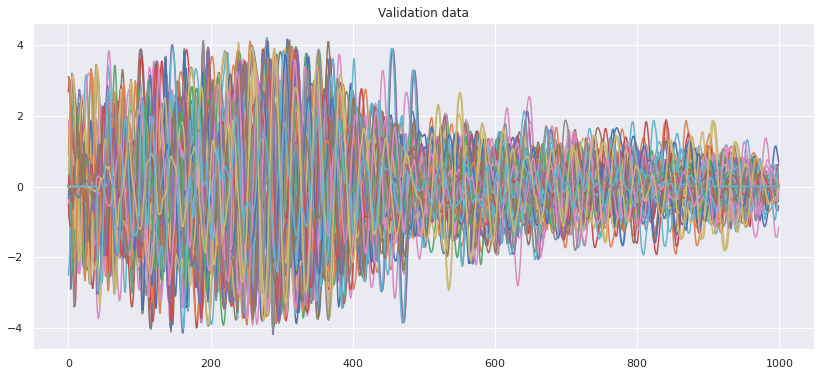

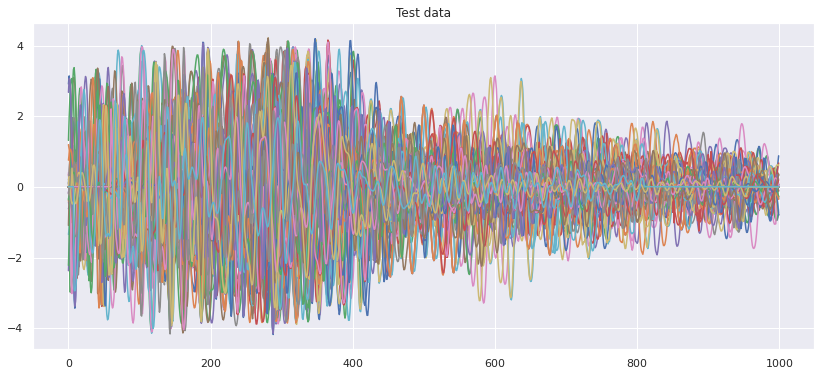

In [134]:
# Get all the data that corresponds to one single class (class 8 / 'I'):
class_num = 1
class_indices = np.where(y_test == class_num)[0]
class_data = x_test[class_indices]
class_output = y_test[class_indices]
class_ann = 'T'   # 'S'for one and 'M' for 2
cnnpredictions = cnnmodel.predict(class_data, verbose=1)
print(f"Validation data mean : {class_data.mean()}")
print(f"Validation data std : {class_data.std()}")
# Get all the data that corresponds to one single class (class 8 / 'I'):
test_class_indices = np.where(y_train == class_num)[0]
test_class_data = x_train[test_class_indices]
test_class_output = y_train[test_class_indices]
test_class_ann = 'T'   # 'S'for one and 'M' for 2
test_cnnpredictions = cnnmodel.predict(class_data, verbose=1)
plt.figure(figsize=(14, 6))
plt.title('Validation data')
for i in range(samples):
    plt.plot(test_class_data[i])
print(f"Test data mean : {test_class_data.mean()}")
print(f"Test data std : {test_class_data.std()}")
# print(test_class_output.shap)
plt.figure(figsize=(14, 6))
plt.title('Test data')
for i in range(samples):
    plt.plot(class_data[i])

In [114]:
import math

from scipy import spatial


def calculate_cosine_distance(a, b):
    cosine_distance = float(spatial.distance.cosine(a, b))
    return cosine_distance


def calculate_cosine_similarity(a, b):
    cosine_similarity = 1 - calculate_cosine_distance(a, b)
    return cosine_similarity


def calculate_angular_distance(a, b):
    cosine_similarity = calculate_cosine_similarity(a, b)
    angular_distance = math.acos(cosine_similarity) / math.pi
    return angular_distance


def calculate_angular_similarity(a, b):
    angular_similarity = 1 - calculate_angular_distance(a, b)
    return angular_similarity

In [122]:
distances=[]
cos_similiarities=[]
angular_distances=[]
angular_similarities=[]
for i in range(1500):
    distances.append(calculate_cosine_distance(x_test[i],x_temp_data[i]))
    cos_similiarities.append(calculate_cosine_similarity(x_test[i],x_temp_data[i]))
    angular_distances.append(calculate_angular_distance(x_test[i],x_temp_data[i]))
    angular_similarities.append(calculate_angular_similarity(x_test[i],x_temp_data[i]))

distances=np.array(distances)
cos_similiarities=np.array(cos_similiarities)
angular_distances=np.array(angular_distances)
angular_similarities=np.array(angular_similarities)
print(distances.mean())
print(cos_similiarities.mean())
print(angular_distances.mean())
print(angular_similarities.mean())

0.9914042985046398
0.008595701495360118
0.49717776626806115
0.5028222337319388


In [121]:
distances=[]
cos_similiarities=[]
angular_distances=[]
angular_similarities=[]
for i in range(1500):
    distances.append(calculate_cosine_distance(x_test[i],x_val[i]))
    cos_similiarities.append(calculate_cosine_similarity(x_test[i],x_val[i]))
    angular_distances.append(calculate_angular_distance(x_test[i],x_val[i]))
    angular_similarities.append(calculate_angular_similarity(x_test[i],x_val[i]))

distances=np.array(distances)
cos_similiarities=np.array(cos_similiarities)
angular_distances=np.array(angular_distances)
angular_similarities=np.array(angular_similarities)
print(distances.mean())
print(cos_similiarities.mean())
print(angular_distances.mean())
print(angular_similarities.mean())

0.9939891054300825
0.006010894569917582
0.49772038939273155
0.5022796106072684


### Create a performance metrics function

In [35]:
def showResults(test, pred, model_name):
    accuracy = accuracy_score(test, pred)
    precision= precision_score(test, pred, average='macro')
    recall = recall_score(test, pred, average = 'macro')
    f1score= f1_score(test, pred, average='macro') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("f1score : {}".format(f1score))
    cm=confusion_matrix(test, pred, labels=[0,1,2])
    return (model_name, round(accuracy,3), round(precision,3) , round(recall,3) , round(f1score,3), cm)

In [36]:
from sklearn.utils import shuffle
shuffled_x, shuffled_y = shuffle(x_temp_data, y_temp_data, random_state=SEED)

In [37]:
class_num = 0
class_indices = np.where(shuffled_y == class_num)[0]
class_data = shuffled_x[class_indices]
class_output = shuffled_y[class_indices]
class_ann = 'T'   # 'S'for one and 'M' for 2
cnnpredictions = cnnmodel.predict(class_data, verbose=1)

18/18 [==============================] - 0s 805us/step


### Call the performance metrics function per class

Accuracy  : 0.8563636363636363
Precision : 0.3333333333333333
Recall : 0.28545454545454546
f1score : 0.3075416258570029


/home/veysiadn/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_40335/3702700.py:8: RuntimeWarning: invalid value encountered in true_divide
  CNN_cf_m = cnn_results[5].astype('float')/ cnn_results[5].sum(axis=1)[:,np.newaxis]


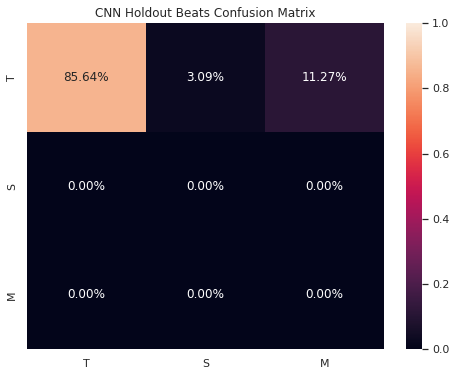

In [38]:
cnn_predict=np.argmax(cnnpredictions,axis=1)
cnn_actual_value=np.reshape(np.array(class_output,dtype='int32'),(len(class_output),))
cnn_results = showResults(cnn_actual_value, cnn_predict,'CNN')

# Plot confusion matrix:
categories=['T','S','M']
fig = plt.figure(figsize=(8,6))
CNN_cf_m = cnn_results[5].astype('float')/ cnn_results[5].sum(axis=1)[:,np.newaxis]
sns.heatmap(np.nan_to_num(CNN_cf_m),annot=True,fmt='.2%',xticklabels=categories,yticklabels=categories,vmin=0,vmax=1,cmap='rocket')
plt.title('CNN Holdout Beats Confusion Matrix')
plt.show()
# fig.savefig('cm.jpg', dpi = 400)

In [39]:
print(cnn_predict.shape)
print(cnn_actual_value.shape)
my_acc = (cnn_predict==cnn_actual_value).sum()/len(cnn_actual_value)
print(my_acc)


(550,)
(550,)
0.8563636363636363


### Compute Grad-CAM values for the class chosen above

In [40]:
# Turn off the final Softmax activation function:
cnnmodel.layers[-1].activation = None

In [41]:
# Create a model that maps the input heartbeat to the feature maps of the last convolutional layer 
# and the output (before applying Softmax):
grad_model = tf.keras.models.Model([cnnmodel.inputs], [cnnmodel.get_layer('last_conv_layer').output, cnnmodel.output])

# Step 1: Compute the gradient of the output with respect to the feature maps:
with tf.GradientTape() as tape:
    last_conv_layer_features, y_predictions = grad_model(class_data)
grads = tape.gradient(y_predictions, last_conv_layer_features)

# Step 2: Calculate alpha values by averaging the gradients:
alpha_values = tf.reduce_mean(grads, axis = 1)

# Step 3: Use the alpha values as the weight of the corresponding feature map: 
gradcam = tf.linalg.matmul(last_conv_layer_features, alpha_values[..., tf.newaxis])

In [42]:
# Normalize the grad-CAM values for visualization:
gradcam = gradcam.numpy()
gradcam = np.abs(gradcam)
gradcam_norm = (gradcam - np.min(gradcam, axis = 1, keepdims = True)) / (np.max(gradcam, axis = 1, keepdims = True) - 
                                                        np.min(gradcam, axis = 1, keepdims = True))
y_predictions = tf.nn.softmax(y_predictions)
y_predictions = y_predictions.numpy()

/tmp/ipykernel_40335/3175498407.py:4: RuntimeWarning: invalid value encountered in true_divide
  gradcam_norm = (gradcam - np.min(gradcam, axis = 1, keepdims = True)) / (np.max(gradcam, axis = 1, keepdims = True) -


### Visualize Grad-CAM results with saliency maps for the correctly classified sounds

471


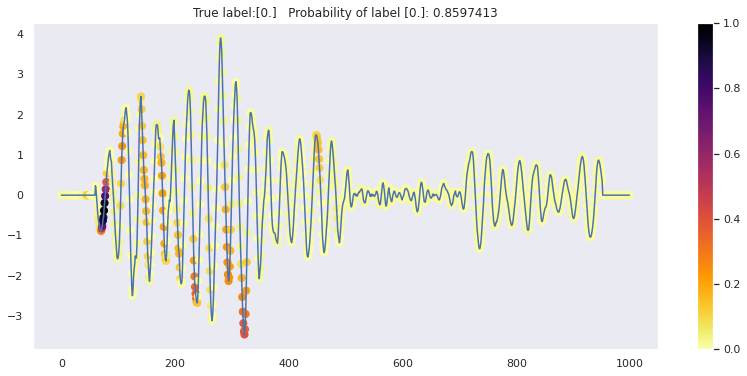

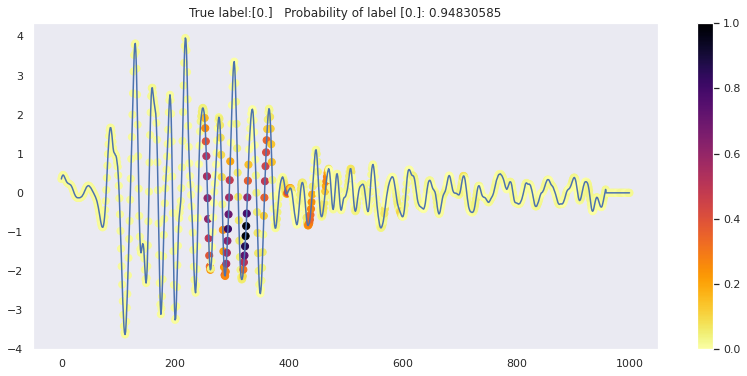

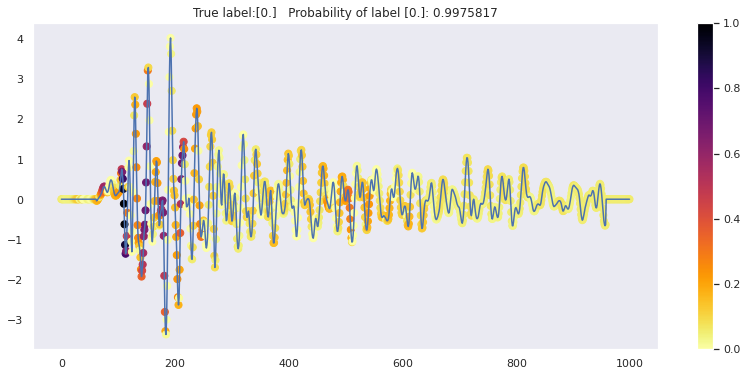

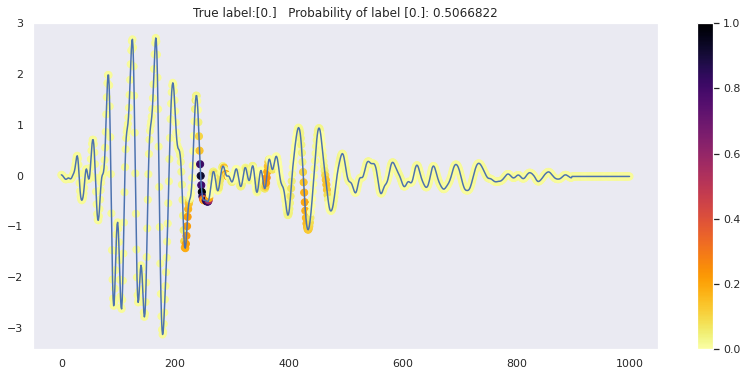

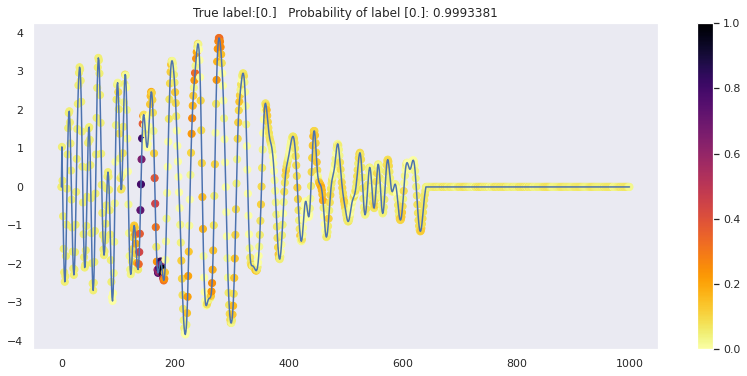

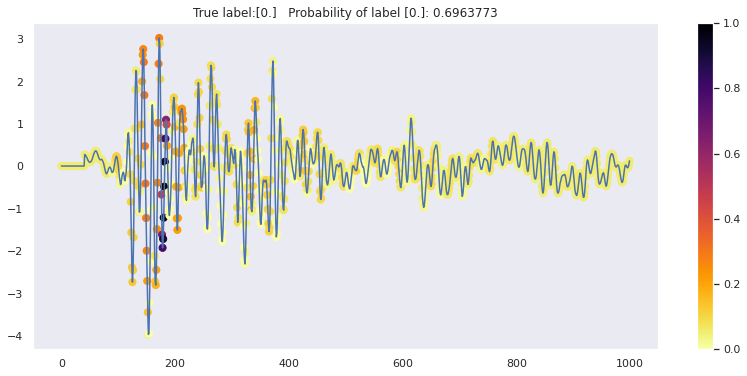

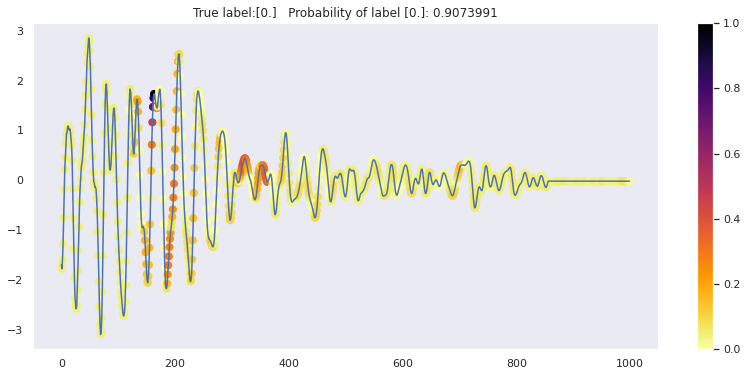

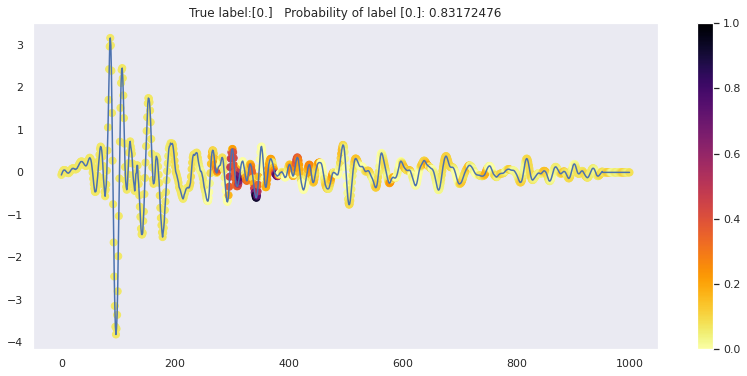

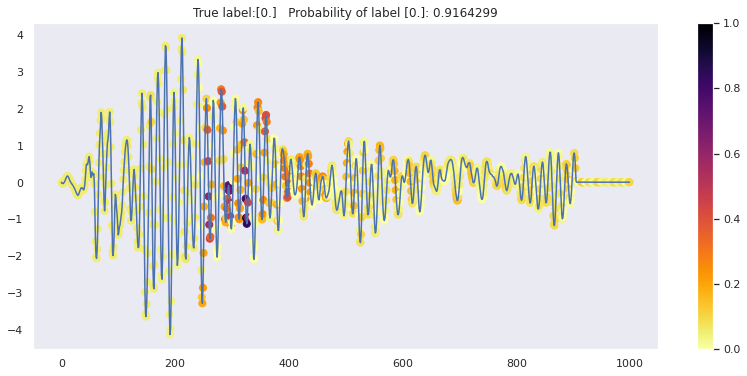

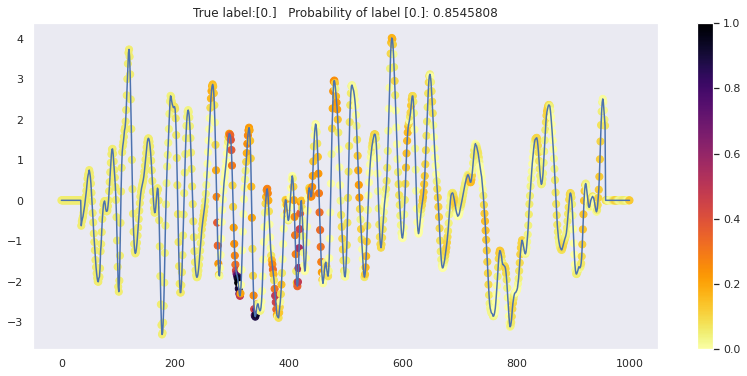

In [43]:
import warnings
warnings.filterwarnings('ignore')
# Get the corectly classified data:
correct_cnn = np.where(cnn_predict == cnn_actual_value)
correct_cnn = correct_cnn[0].tolist()
print(len(correct_cnn))
# Plot a few examples of heatmaps:

for i in correct_cnn[10:20]:
    # plt.figure(figsize=(20, 8),dpi=100)
    plt.figure(figsize=(14, 6))
    plt.grid(False)
    plt.plot(x_test[i].squeeze())
    plt.scatter(np.arange(len(class_data[i])), x_test[i].squeeze(), cmap='inferno_r', c=gradcam_norm[i,:].squeeze(), s=50)
    plt.title('True label:' + str(class_output[i]) + '   Probability of label ' + str(class_output[i]) + ': ' + str(y_predictions[i, int(class_output[i])]))
    clim= np.ravel(gradcam_norm)
    plt.clim(min(clim),max(clim))
    plt.colorbar()
    plt.show

### Visualize Grad-CAM results with saliency maps for the sounds that were not correctly classified

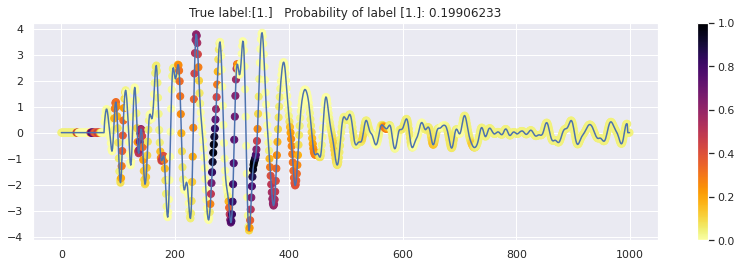

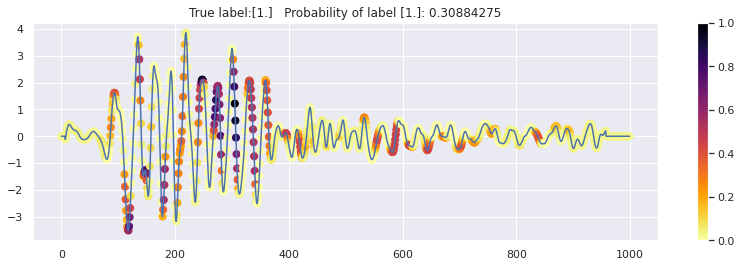

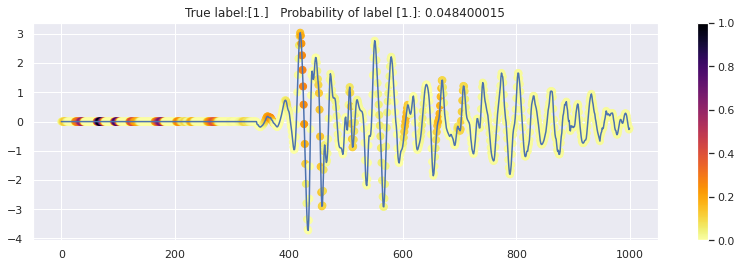

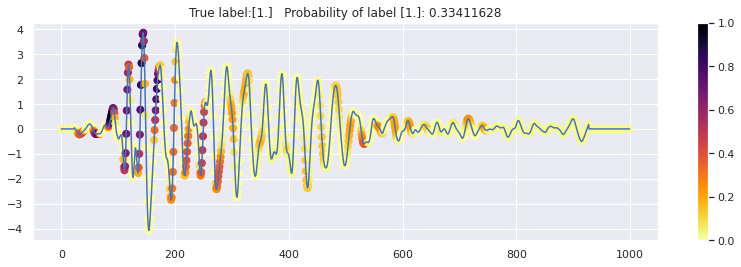

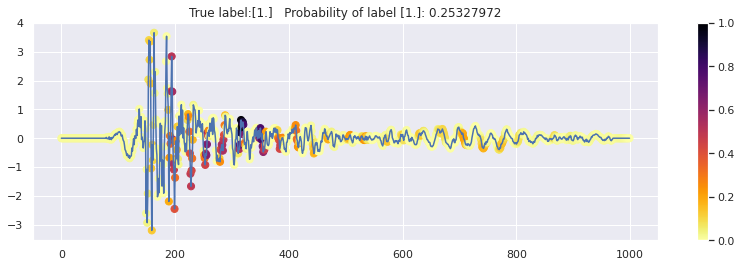

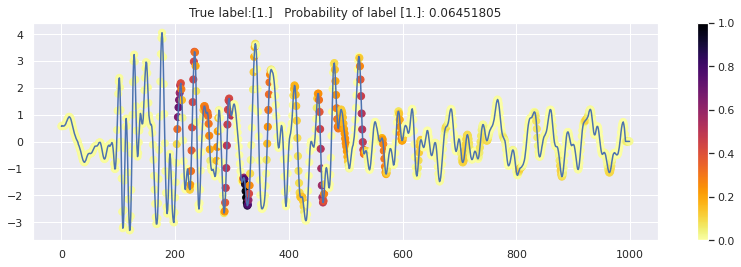

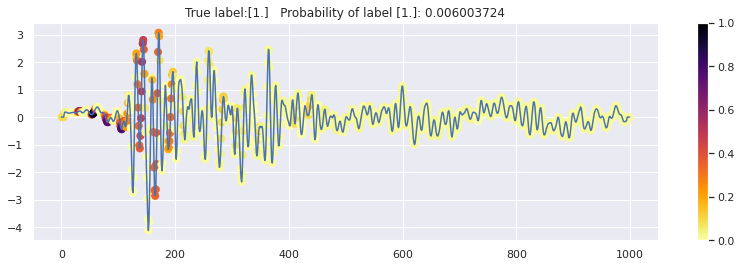

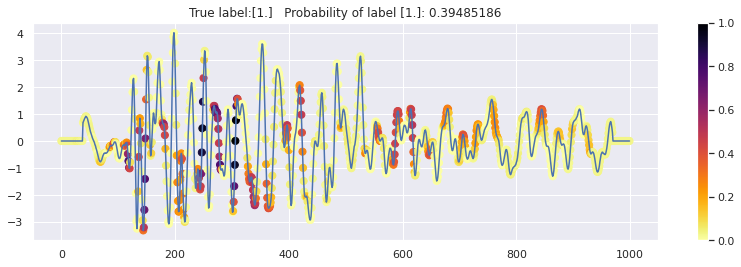

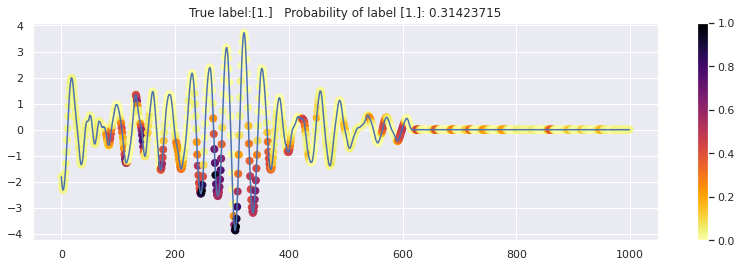

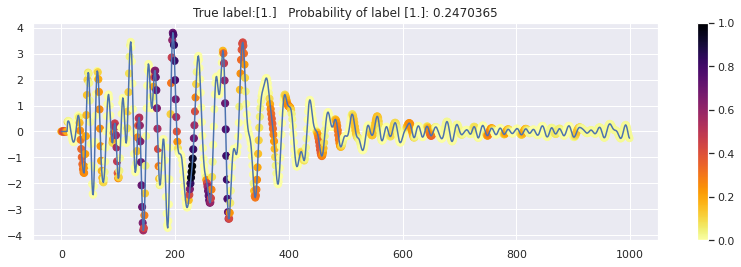

In [28]:
# Get the misclassified data:
misclass_cnn = np.where(cnn_predict!=cnn_actual_value)
misclass_cnn = misclass_cnn[0].tolist()

# Plot a few examples of heatmaps:
for i in misclass_cnn[10:20]:
    plt.figure(figsize=(14, 4))
    plt.plot(x_test[i].squeeze())
    plt.scatter(np.arange(len(class_data[i])), x_test[i].squeeze(), cmap='inferno_r', c=gradcam_norm[i,:].squeeze(), s=50)
    plt.title('True label:' + str(class_output[i]) + '   Probability of label ' + str(class_output[i]) + ': ' + str(y_predictions[i, int(class_output[i])]))
    clim= np.ravel(gradcam_norm)
    plt.clim(min(clim),max(clim))
    plt.colorbar()
    plt.show

### Divide the sounds into 3 segments and compute the Grad-CAM values per segment

In [32]:
# Means of slice function:
def means_of_slices(iterable, slice_size):
    iterator = iter(iterable)
    while True:
        slice = list(islice(iterator, slice_size))
        if slice:
            yield np.sum(slice)/len(slice)
        else:
            return

# Divide the result into slices:
cam_per_segment = []
for i in range(class_data.shape[0]):
    means = list(means_of_slices(gradcam_norm[i], 25))
    cam_per_segment.append(means)
cam_per_segment = np.array(cam_per_segment)
print(cam_per_segment.shape)

# Repeat the values 25 times for visualization purposes:
cam_per_segment_repeat = []
for i in cam_per_segment:
    cam_per_segment_repeat.append(np.repeat(i,25))
cam_per_segment_repeat = np.array(cam_per_segment_repeat)
print(cam_per_segment_repeat.shape)

(821, 40)
(821, 1000)


### Plot the average Grad-CAM values per segment on a sample sound

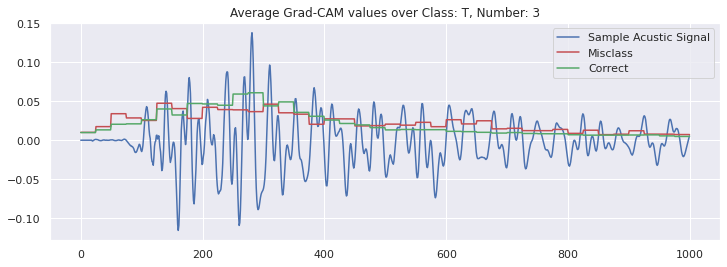

In [33]:
# Normalize correct and incorrect predictions:
ae_correct_norm = np.nan_to_num(normalize(cam_per_segment_repeat[correct_cnn[:1000]]))
ae_incorrect_norm = normalize(cam_per_segment_repeat[misclass_cnn[:10]])

# Normalize ECG heartbeat example:
ae_norml = normalize(class_data)

# Take means of all correct and incorrect segments:
mean_correct = ae_correct_norm.mean(axis=0)
mean_incorrect = ae_incorrect_norm.mean(axis=0)

# Visualize:
plt.figure(figsize=(12,4))
plt.plot(ae_norml[1],color='b',label='Sample Acustic Signal')
plt.plot(np.abs(mean_incorrect), color='r', label='Misclass')
plt.plot(np.abs(mean_correct), color='g', label='Correct')
plt.title('Average Grad-CAM values over '+'Class: ' + 'T' +', Number: ' + str(3))
plt.legend()
# plt.savefig('cnn_gradcam_' + 'T' + '.jpg', bbox_inches='tight',dpi=400)
plt.show()

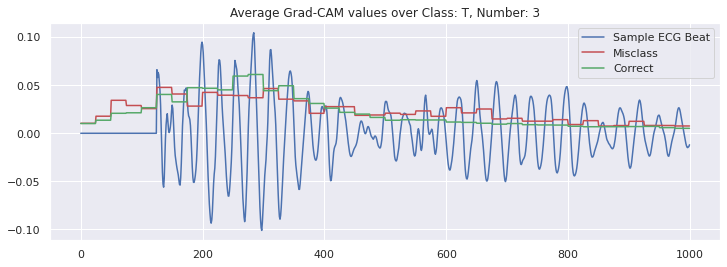

In [34]:
# Normalize correct and incorrect predictions:
ae_correct_norm = np.nan_to_num(normalize(cam_per_segment_repeat[correct_cnn[:1000]]))
ae_incorrect_norm = normalize(cam_per_segment_repeat[misclass_cnn[:10]])

# Normalize ECG heartbeat example:
ae_norml = normalize(x_test)

# Take means of all correct and incorrect segments:
mean_correct = ae_correct_norm.mean(axis=0)
mean_incorrect = ae_incorrect_norm.mean(axis=0)

# Visualize:
plt.figure(figsize=(12,4))
plt.plot(ae_norml[3],color='b',label='Sample ECG Beat')
plt.plot(np.abs(mean_incorrect), color='r', label='Misclass')
plt.plot(np.abs(mean_correct), color='g', label='Correct')
plt.title('Average Grad-CAM values over '+'Class: ' + 'T' +', Number: ' + str(3))
plt.legend()
# plt.savefig('cnn_gradcam_' + 'T' + '.jpg', bbox_inches='tight',dpi=400)
plt.show()